# Sciplex Dose

In [1]:
ood_seed = 2

In [2]:
num_ood = 1

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

52

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('BMS', '50.0'), 34)


Removed datapoint: 34

train         11817
validation     2960
ood              34
Name: split, dtype: int64

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="condition",
    control_group="Vehicle",
    dosage_key="dose_val",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['cell_type']
)

  0%|          | 0/14811 [00:00<?, ?it/s]

 65%|██████▍   | 9593/14811 [00:00<00:00, 95920.72it/s]

100%|██████████| 14811/14811 [00:00<00:00, 95942.99it/s]

  0%|          | 0/14811 [00:00<?, ?it/s]

100%|██████████| 14811/14811 [00:00<00:00, 955676.45it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [13]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [14]:
model.train(max_epochs=400)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 164.09it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:04<29:53,  4.50s/it]

Epoch 1/400:   0%|          | 1/400 [00:04<29:53,  4.50s/it, v_num=1, recon=3.07e+3, r2_mean=0.135, adv_loss=1.47, acc_pert=0.351]

Epoch 2/400:   0%|          | 1/400 [00:04<29:53,  4.50s/it, v_num=1, recon=3.07e+3, r2_mean=0.135, adv_loss=1.47, acc_pert=0.351]

Epoch 2/400:   0%|          | 2/400 [00:07<25:26,  3.84s/it, v_num=1, recon=3.07e+3, r2_mean=0.135, adv_loss=1.47, acc_pert=0.351]

Epoch 2/400:   0%|          | 2/400 [00:07<25:26,  3.84s/it, v_num=1, recon=2.34e+3, r2_mean=0.491, adv_loss=1.21, acc_pert=0.542]

Epoch 3/400:   0%|          | 2/400 [00:07<25:26,  3.84s/it, v_num=1, recon=2.34e+3, r2_mean=0.491, adv_loss=1.21, acc_pert=0.542]

Epoch 3/400:   1%|          | 3/400 [00:11<24:06,  3.64s/it, v_num=1, recon=2.34e+3, r2_mean=0.491, adv_loss=1.21, acc_pert=0.542]

Epoch 3/400:   1%|          | 3/400 [00:11<24:06,  3.64s/it, v_num=1, recon=2.19e+3, r2_mean=0.608, adv_loss=1.09, acc_pert=0.587]

Epoch 4/400:   1%|          | 3/400 [00:11<24:06,  3.64s/it, v_num=1, recon=2.19e+3, r2_mean=0.608, adv_loss=1.09, acc_pert=0.587]

Epoch 4/400:   1%|          | 4/400 [00:14<23:24,  3.55s/it, v_num=1, recon=2.19e+3, r2_mean=0.608, adv_loss=1.09, acc_pert=0.587]

Epoch 4/400:   1%|          | 4/400 [00:14<23:24,  3.55s/it, v_num=1, recon=2.15e+3, r2_mean=0.675, adv_loss=1.02, acc_pert=0.618]

Epoch 5/400:   1%|          | 4/400 [00:14<23:24,  3.55s/it, v_num=1, recon=2.15e+3, r2_mean=0.675, adv_loss=1.02, acc_pert=0.618]

Epoch 5/400:   1%|▏         | 5/400 [00:18<22:57,  3.49s/it, v_num=1, recon=2.15e+3, r2_mean=0.675, adv_loss=1.02, acc_pert=0.618]

Epoch 5/400:   1%|▏         | 5/400 [00:18<22:57,  3.49s/it, v_num=1, recon=2.13e+3, r2_mean=0.719, adv_loss=0.963, acc_pert=0.641]

Epoch 6/400:   1%|▏         | 5/400 [00:18<22:57,  3.49s/it, v_num=1, recon=2.13e+3, r2_mean=0.719, adv_loss=0.963, acc_pert=0.641]

Epoch 6/400:   2%|▏         | 6/400 [00:21<22:38,  3.45s/it, v_num=1, recon=2.13e+3, r2_mean=0.719, adv_loss=0.963, acc_pert=0.641]

Epoch 6/400:   2%|▏         | 6/400 [00:21<22:38,  3.45s/it, v_num=1, recon=2.12e+3, r2_mean=0.749, adv_loss=0.925, acc_pert=0.658]

Epoch 7/400:   2%|▏         | 6/400 [00:21<22:38,  3.45s/it, v_num=1, recon=2.12e+3, r2_mean=0.749, adv_loss=0.925, acc_pert=0.658]

Epoch 7/400:   2%|▏         | 7/400 [00:24<22:24,  3.42s/it, v_num=1, recon=2.12e+3, r2_mean=0.749, adv_loss=0.925, acc_pert=0.658]

Epoch 7/400:   2%|▏         | 7/400 [00:24<22:24,  3.42s/it, v_num=1, recon=2.11e+3, r2_mean=0.775, adv_loss=0.899, acc_pert=0.665]

Epoch 8/400:   2%|▏         | 7/400 [00:24<22:24,  3.42s/it, v_num=1, recon=2.11e+3, r2_mean=0.775, adv_loss=0.899, acc_pert=0.665]

Epoch 8/400:   2%|▏         | 8/400 [00:28<22:17,  3.41s/it, v_num=1, recon=2.11e+3, r2_mean=0.775, adv_loss=0.899, acc_pert=0.665]

Epoch 8/400:   2%|▏         | 8/400 [00:28<22:17,  3.41s/it, v_num=1, recon=2.11e+3, r2_mean=0.795, adv_loss=0.881, acc_pert=0.678]

Epoch 9/400:   2%|▏         | 8/400 [00:28<22:17,  3.41s/it, v_num=1, recon=2.11e+3, r2_mean=0.795, adv_loss=0.881, acc_pert=0.678]

Epoch 9/400:   2%|▏         | 9/400 [00:31<22:11,  3.41s/it, v_num=1, recon=2.11e+3, r2_mean=0.795, adv_loss=0.881, acc_pert=0.678]

Epoch 9/400:   2%|▏         | 9/400 [00:31<22:11,  3.41s/it, v_num=1, recon=2.1e+3, r2_mean=0.813, adv_loss=0.858, acc_pert=0.683] 

Epoch 10/400:   2%|▏         | 9/400 [00:31<22:11,  3.41s/it, v_num=1, recon=2.1e+3, r2_mean=0.813, adv_loss=0.858, acc_pert=0.683]


disnt_basal = 0.4061003754232903

disnt_after = 0.40663849981209815

val_r2_mean = 0.8160422369837761

val_r2_var = 0.2856629918018977


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:54<1:01:35,  9.48s/it, v_num=1, recon=2.1e+3, r2_mean=0.813, adv_loss=0.858, acc_pert=0.683]

Epoch 10/400:   2%|▎         | 10/400 [00:54<1:01:35,  9.48s/it, v_num=1, recon=2.1e+3, r2_mean=0.827, adv_loss=0.836, acc_pert=0.691, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:54<1:01:35,  9.48s/it, v_num=1, recon=2.1e+3, r2_mean=0.827, adv_loss=0.836, acc_pert=0.691, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:57<49:07,  7.58s/it, v_num=1, recon=2.1e+3, r2_mean=0.827, adv_loss=0.836, acc_pert=0.691, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]  

Epoch 11/400:   3%|▎         | 11/400 [00:57<49:07,  7.58s/it, v_num=1, recon=2.1e+3, r2_mean=0.837, adv_loss=0.829, acc_pert=0.698, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:57<49:07,  7.58s/it, v_num=1, recon=2.1e+3, r2_mean=0.837, adv_loss=0.829, acc_pert=0.698, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:01<41:01,  6.34s/it, v_num=1, recon=2.1e+3, r2_mean=0.837, adv_loss=0.829, acc_pert=0.698, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:01<41:01,  6.34s/it, v_num=1, recon=2.09e+3, r2_mean=0.848, adv_loss=0.816, acc_pert=0.698, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [01:01<41:01,  6.34s/it, v_num=1, recon=2.09e+3, r2_mean=0.848, adv_loss=0.816, acc_pert=0.698, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:05<37:13,  5.77s/it, v_num=1, recon=2.09e+3, r2_mean=0.848, adv_loss=0.816, acc_pert=0.698, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:05<37:13,  5.77s/it, v_num=1, recon=2.09e+3, r2_mean=0.856, adv_loss=0.822, acc_pert=0.702, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [01:05<37:13,  5.77s/it, v_num=1, recon=2.09e+3, r2_mean=0.856, adv_loss=0.822, acc_pert=0.702, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:09<32:43,  5.09s/it, v_num=1, recon=2.09e+3, r2_mean=0.856, adv_loss=0.822, acc_pert=0.702, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:09<32:43,  5.09s/it, v_num=1, recon=2.09e+3, r2_mean=0.863, adv_loss=0.813, acc_pert=0.701, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [01:09<32:43,  5.09s/it, v_num=1, recon=2.09e+3, r2_mean=0.863, adv_loss=0.813, acc_pert=0.701, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:16<36:36,  5.71s/it, v_num=1, recon=2.09e+3, r2_mean=0.863, adv_loss=0.813, acc_pert=0.701, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:16<36:36,  5.71s/it, v_num=1, recon=2.08e+3, r2_mean=0.867, adv_loss=0.811, acc_pert=0.702, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [01:16<36:36,  5.71s/it, v_num=1, recon=2.08e+3, r2_mean=0.867, adv_loss=0.811, acc_pert=0.702, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:20<32:39,  5.10s/it, v_num=1, recon=2.08e+3, r2_mean=0.867, adv_loss=0.811, acc_pert=0.702, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:20<32:39,  5.10s/it, v_num=1, recon=2.08e+3, r2_mean=0.871, adv_loss=0.798, acc_pert=0.702, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [01:20<32:39,  5.10s/it, v_num=1, recon=2.08e+3, r2_mean=0.871, adv_loss=0.798, acc_pert=0.702, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:23<29:20,  4.60s/it, v_num=1, recon=2.08e+3, r2_mean=0.871, adv_loss=0.798, acc_pert=0.702, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:23<29:20,  4.60s/it, v_num=1, recon=2.08e+3, r2_mean=0.875, adv_loss=0.797, acc_pert=0.707, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [01:23<29:20,  4.60s/it, v_num=1, recon=2.08e+3, r2_mean=0.875, adv_loss=0.797, acc_pert=0.707, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:27<27:06,  4.26s/it, v_num=1, recon=2.08e+3, r2_mean=0.875, adv_loss=0.797, acc_pert=0.707, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:27<27:06,  4.26s/it, v_num=1, recon=2.08e+3, r2_mean=0.879, adv_loss=0.792, acc_pert=0.71, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan] 

Epoch 19/400:   4%|▍         | 18/400 [01:27<27:06,  4.26s/it, v_num=1, recon=2.08e+3, r2_mean=0.879, adv_loss=0.792, acc_pert=0.71, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:30<26:05,  4.11s/it, v_num=1, recon=2.08e+3, r2_mean=0.879, adv_loss=0.792, acc_pert=0.71, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:30<26:05,  4.11s/it, v_num=1, recon=2.07e+3, r2_mean=0.881, adv_loss=0.785, acc_pert=0.71, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:30<26:05,  4.11s/it, v_num=1, recon=2.07e+3, r2_mean=0.881, adv_loss=0.785, acc_pert=0.71, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]


disnt_basal = 0.4285697228429716

disnt_after = 0.42978992779590536

val_r2_mean = 0.8694896045658324

val_r2_var = 0.3536718181437916


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [02:06<1:26:47, 13.70s/it, v_num=1, recon=2.07e+3, r2_mean=0.881, adv_loss=0.785, acc_pert=0.71, val_recon=2.12e+3, disnt_basal=0.406, disnt_after=0.407, val_r2_mean=0.816, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [02:06<1:26:47, 13.70s/it, v_num=1, recon=2.07e+3, r2_mean=0.882, adv_loss=0.784, acc_pert=0.709, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [02:06<1:26:47, 13.70s/it, v_num=1, recon=2.07e+3, r2_mean=0.882, adv_loss=0.784, acc_pert=0.709, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [02:10<1:07:16, 10.65s/it, v_num=1, recon=2.07e+3, r2_mean=0.882, adv_loss=0.784, acc_pert=0.709, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [02:10<1:07:16, 10.65s/it, v_num=1, recon=2.07e+3, r2_mean=0.883, adv_loss=0.781, acc_pert=0.706, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [02:10<1:07:16, 10.65s/it, v_num=1, recon=2.07e+3, r2_mean=0.883, adv_loss=0.781, acc_pert=0.706, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [02:14<53:39,  8.52s/it, v_num=1, recon=2.07e+3, r2_mean=0.883, adv_loss=0.781, acc_pert=0.706, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]  

Epoch 22/400:   6%|▌         | 22/400 [02:14<53:39,  8.52s/it, v_num=1, recon=2.07e+3, r2_mean=0.885, adv_loss=0.779, acc_pert=0.713, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [02:14<53:39,  8.52s/it, v_num=1, recon=2.07e+3, r2_mean=0.885, adv_loss=0.779, acc_pert=0.713, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [02:17<44:01,  7.01s/it, v_num=1, recon=2.07e+3, r2_mean=0.885, adv_loss=0.779, acc_pert=0.713, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [02:17<44:01,  7.01s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.77, acc_pert=0.71, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]  

Epoch 24/400:   6%|▌         | 23/400 [02:17<44:01,  7.01s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.77, acc_pert=0.71, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [02:21<37:29,  5.98s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.77, acc_pert=0.71, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [02:21<37:29,  5.98s/it, v_num=1, recon=2.06e+3, r2_mean=0.886, adv_loss=0.77, acc_pert=0.716, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [02:21<37:29,  5.98s/it, v_num=1, recon=2.06e+3, r2_mean=0.886, adv_loss=0.77, acc_pert=0.716, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [02:24<32:42,  5.23s/it, v_num=1, recon=2.06e+3, r2_mean=0.886, adv_loss=0.77, acc_pert=0.716, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [02:24<32:42,  5.23s/it, v_num=1, recon=2.06e+3, r2_mean=0.886, adv_loss=0.765, acc_pert=0.713, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [02:24<32:42,  5.23s/it, v_num=1, recon=2.06e+3, r2_mean=0.886, adv_loss=0.765, acc_pert=0.713, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [02:27<29:07,  4.67s/it, v_num=1, recon=2.06e+3, r2_mean=0.886, adv_loss=0.765, acc_pert=0.713, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [02:27<29:07,  4.67s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.764, acc_pert=0.714, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [02:27<29:07,  4.67s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.764, acc_pert=0.714, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:31<26:38,  4.28s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.764, acc_pert=0.714, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:31<26:38,  4.28s/it, v_num=1, recon=2.06e+3, r2_mean=0.888, adv_loss=0.757, acc_pert=0.714, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [02:31<26:38,  4.28s/it, v_num=1, recon=2.06e+3, r2_mean=0.888, adv_loss=0.757, acc_pert=0.714, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:34<24:58,  4.03s/it, v_num=1, recon=2.06e+3, r2_mean=0.888, adv_loss=0.757, acc_pert=0.714, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:34<24:58,  4.03s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.758, acc_pert=0.718, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan] 

Epoch 29/400:   7%|▋         | 28/400 [02:34<24:58,  4.03s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.758, acc_pert=0.718, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:38<23:42,  3.83s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.758, acc_pert=0.718, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:38<23:42,  3.83s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.753, acc_pert=0.717, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [02:38<23:42,  3.83s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.753, acc_pert=0.717, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]


disnt_basal = 0.4322968945007144

disnt_after = 0.4336924796935757

val_r2_mean = 0.8760477463404338

val_r2_var = 0.3719503954052925


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [03:00<57:23,  9.31s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.753, acc_pert=0.717, val_recon=2.07e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.869, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [03:00<57:23,  9.31s/it, v_num=1, recon=2.05e+3, r2_mean=0.889, adv_loss=0.747, acc_pert=0.725, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [03:00<57:23,  9.31s/it, v_num=1, recon=2.05e+3, r2_mean=0.889, adv_loss=0.747, acc_pert=0.725, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [03:03<46:09,  7.50s/it, v_num=1, recon=2.05e+3, r2_mean=0.889, adv_loss=0.747, acc_pert=0.725, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [03:03<46:09,  7.50s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.745, acc_pert=0.718, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [03:03<46:09,  7.50s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.745, acc_pert=0.718, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [03:06<38:11,  6.23s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.745, acc_pert=0.718, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [03:06<38:11,  6.23s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.741, acc_pert=0.728, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [03:06<38:11,  6.23s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.741, acc_pert=0.728, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [03:10<32:39,  5.34s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.741, acc_pert=0.728, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [03:10<32:39,  5.34s/it, v_num=1, recon=2.04e+3, r2_mean=0.89, adv_loss=0.739, acc_pert=0.728, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan] 

Epoch 34/400:   8%|▊         | 33/400 [03:10<32:39,  5.34s/it, v_num=1, recon=2.04e+3, r2_mean=0.89, adv_loss=0.739, acc_pert=0.728, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [03:13<28:47,  4.72s/it, v_num=1, recon=2.04e+3, r2_mean=0.89, adv_loss=0.739, acc_pert=0.728, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [03:13<28:47,  4.72s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.732, acc_pert=0.73, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [03:13<28:47,  4.72s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.732, acc_pert=0.73, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [03:16<26:02,  4.28s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.732, acc_pert=0.73, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [03:16<26:02,  4.28s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.735, acc_pert=0.726, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [03:16<26:02,  4.28s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.735, acc_pert=0.726, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [03:19<24:13,  3.99s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.735, acc_pert=0.726, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [03:19<24:13,  3.99s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.724, acc_pert=0.729, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [03:19<24:13,  3.99s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.724, acc_pert=0.729, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [03:23<22:53,  3.78s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.724, acc_pert=0.729, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [03:23<22:53,  3.78s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.723, acc_pert=0.734, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [03:23<22:53,  3.78s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.723, acc_pert=0.734, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [03:26<22:01,  3.65s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.723, acc_pert=0.734, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [03:26<22:01,  3.65s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.725, acc_pert=0.732, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [03:26<22:01,  3.65s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.725, acc_pert=0.732, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:29<21:19,  3.54s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.725, acc_pert=0.732, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:29<21:19,  3.54s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.719, acc_pert=0.735, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [03:29<21:19,  3.54s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.719, acc_pert=0.735, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]


disnt_basal = 0.4256094521531802

disnt_after = 0.42701687972205443

val_r2_mean = 0.8775818482041359

val_r2_var = 0.38651076207558316


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [03:55<1:00:42, 10.12s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.719, acc_pert=0.735, val_recon=2.06e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.876, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [03:55<1:00:42, 10.12s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.723, acc_pert=0.735, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [03:55<1:00:42, 10.12s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.723, acc_pert=0.735, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:58<48:34,  8.12s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.723, acc_pert=0.735, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]  

Epoch 41/400:  10%|█         | 41/400 [03:58<48:34,  8.12s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.722, acc_pert=0.731, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [03:58<48:34,  8.12s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.722, acc_pert=0.731, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [04:02<39:51,  6.68s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.722, acc_pert=0.731, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [04:02<39:51,  6.68s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.713, acc_pert=0.738, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [04:02<39:51,  6.68s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.713, acc_pert=0.738, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [04:05<33:53,  5.70s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.713, acc_pert=0.738, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [04:05<33:53,  5.70s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.713, acc_pert=0.74, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan] 

Epoch 44/400:  11%|█         | 43/400 [04:05<33:53,  5.70s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.713, acc_pert=0.74, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [04:08<29:41,  5.01s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.713, acc_pert=0.74, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [04:08<29:41,  5.01s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.713, acc_pert=0.739, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [04:08<29:41,  5.01s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.713, acc_pert=0.739, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [04:12<26:47,  4.53s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.713, acc_pert=0.739, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [04:12<26:47,  4.53s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.713, acc_pert=0.738, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [04:12<26:47,  4.53s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.713, acc_pert=0.738, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [04:15<24:44,  4.19s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.713, acc_pert=0.738, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [04:15<24:44,  4.19s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.71, acc_pert=0.74, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]  

Epoch 47/400:  12%|█▏        | 46/400 [04:15<24:44,  4.19s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.71, acc_pert=0.74, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [04:19<23:11,  3.94s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.71, acc_pert=0.74, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [04:19<23:11,  3.94s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.706, acc_pert=0.742, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [04:19<23:11,  3.94s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.706, acc_pert=0.742, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [04:22<22:07,  3.77s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.706, acc_pert=0.742, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [04:22<22:07,  3.77s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.707, acc_pert=0.741, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [04:22<22:07,  3.77s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.707, acc_pert=0.741, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [04:25<21:28,  3.67s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.707, acc_pert=0.741, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [04:25<21:28,  3.67s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.707, acc_pert=0.735, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [04:25<21:28,  3.67s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.707, acc_pert=0.735, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]


disnt_basal = 0.4266641763411298

disnt_after = 0.4283752006389248

val_r2_mean = 0.8803873325387638

val_r2_var = 0.4010863055785497


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [04:53<1:02:46, 10.76s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.707, acc_pert=0.735, val_recon=2.05e+3, disnt_basal=0.426, disnt_after=0.427, val_r2_mean=0.878, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [04:53<1:02:46, 10.76s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.698, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan] 

Epoch 51/400:  12%|█▎        | 50/400 [04:53<1:02:46, 10.76s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.698, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:56<49:41,  8.54s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.698, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]  

Epoch 51/400:  13%|█▎        | 51/400 [04:56<49:41,  8.54s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.703, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [04:56<49:41,  8.54s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.703, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:59<40:30,  6.99s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.703, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:59<40:30,  6.99s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.702, acc_pert=0.743, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [04:59<40:30,  6.99s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.702, acc_pert=0.743, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [05:03<34:09,  5.91s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.702, acc_pert=0.743, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [05:03<34:09,  5.91s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.698, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [05:03<34:09,  5.91s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.698, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [05:09<34:20,  5.96s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.698, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [05:09<34:20,  5.96s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.694, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [05:09<34:20,  5.96s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.694, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [05:12<29:40,  5.16s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.694, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [05:12<29:40,  5.16s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.697, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [05:12<29:40,  5.16s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.697, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [05:15<26:25,  4.61s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.697, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [05:15<26:25,  4.61s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.699, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [05:15<26:25,  4.61s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.699, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [05:19<24:33,  4.30s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.699, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [05:19<24:33,  4.30s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.694, acc_pert=0.747, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [05:19<24:33,  4.30s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.694, acc_pert=0.747, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [05:22<22:45,  3.99s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.694, acc_pert=0.747, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [05:22<22:45,  3.99s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [05:22<22:45,  3.99s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [05:26<21:22,  3.76s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [05:26<21:22,  3.76s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [05:26<21:22,  3.76s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]


disnt_basal = 0.43551269153745786

disnt_after = 0.43801442301068505

val_r2_mean = 0.8834380706151327

val_r2_var = 0.4124754508336385


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [05:52<59:38, 10.52s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.88, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [05:52<59:38, 10.52s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.693, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [05:52<59:38, 10.52s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.693, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:58<52:07,  9.23s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.693, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:58<52:07,  9.23s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.695, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [05:58<52:07,  9.23s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.695, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [06:01<41:57,  7.45s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.695, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [06:01<41:57,  7.45s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.689, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan] 

Epoch 63/400:  16%|█▌        | 62/400 [06:01<41:57,  7.45s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.689, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [06:05<34:59,  6.23s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.689, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [06:05<34:59,  6.23s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.686, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]   

Epoch 64/400:  16%|█▌        | 63/400 [06:05<34:59,  6.23s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.686, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [06:08<29:58,  5.35s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.686, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [06:08<29:58,  5.35s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.685, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [06:08<29:58,  5.35s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.685, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [06:11<26:28,  4.74s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.685, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [06:11<26:28,  4.74s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.689, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [06:11<26:28,  4.74s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.689, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [06:15<23:59,  4.31s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.689, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [06:15<23:59,  4.31s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.685, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [06:15<23:59,  4.31s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.685, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [06:18<22:10,  4.00s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.685, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [06:18<22:10,  4.00s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.681, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [06:18<22:10,  4.00s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.681, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [06:21<20:53,  3.78s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.681, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [06:21<20:53,  3.78s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.681, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [06:21<20:53,  3.78s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.681, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [06:24<20:00,  3.63s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.681, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [06:24<20:00,  3.63s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.686, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [06:24<20:00,  3.63s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.686, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]


disnt_basal = 0.433404164526936

disnt_after = 0.43508986401630984

val_r2_mean = 0.8799593349297842

val_r2_var = 0.4266034876306852


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [06:49<55:16, 10.05s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.686, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.883, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [06:49<55:16, 10.05s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.678, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan] 

Epoch 71/400:  18%|█▊        | 70/400 [06:49<55:16, 10.05s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.678, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [06:53<44:24,  8.10s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.678, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [06:53<44:24,  8.10s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.677, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [06:53<44:24,  8.10s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.677, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:57<36:44,  6.72s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.677, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:57<36:44,  6.72s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.686, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [06:57<36:44,  6.72s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.686, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [07:00<31:57,  5.86s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.686, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [07:00<31:57,  5.86s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.677, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [07:00<31:57,  5.86s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.677, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [07:04<28:02,  5.16s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.677, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [07:04<28:02,  5.16s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan] 

Epoch 75/400:  18%|█▊        | 74/400 [07:04<28:02,  5.16s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [07:07<25:14,  4.66s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [07:07<25:14,  4.66s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.687, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [07:07<25:14,  4.66s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.687, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [07:11<23:08,  4.29s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.687, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [07:11<23:08,  4.29s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.679, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [07:11<23:08,  4.29s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.679, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [07:14<21:43,  4.04s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.679, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [07:14<21:43,  4.04s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.682, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]  

Epoch 78/400:  19%|█▉        | 77/400 [07:14<21:43,  4.04s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.682, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [07:18<20:27,  3.81s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.682, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [07:18<20:27,  3.81s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.674, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [07:18<20:27,  3.81s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.674, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [07:21<19:38,  3.67s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.674, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [07:21<19:38,  3.67s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan] 

Epoch 80/400:  20%|█▉        | 79/400 [07:21<19:38,  3.67s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]


disnt_basal = 0.4308385420245901

disnt_after = 0.4328259624983604

val_r2_mean = 0.8861548924197753

val_r2_var = 0.4216971935083469


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [07:43<48:51,  9.16s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.88, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [07:43<48:51,  9.16s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan] 

Epoch 81/400:  20%|██        | 80/400 [07:43<48:51,  9.16s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [07:46<39:31,  7.43s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [07:46<39:31,  7.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.669, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [07:46<39:31,  7.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.669, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [07:50<33:06,  6.25s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.669, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [07:50<33:06,  6.25s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.673, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [07:50<33:06,  6.25s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.673, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [07:53<28:42,  5.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.673, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [07:53<28:42,  5.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.675, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [07:53<28:42,  5.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.675, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:57<25:27,  4.83s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.675, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:57<25:27,  4.83s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.669, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]  

Epoch 85/400:  21%|██        | 84/400 [07:57<25:27,  4.83s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.669, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [08:00<23:02,  4.39s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.669, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [08:00<23:02,  4.39s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.67, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan] 

Epoch 86/400:  21%|██▏       | 85/400 [08:00<23:02,  4.39s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.67, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [08:03<21:24,  4.09s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.67, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [08:03<21:24,  4.09s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.67, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [08:04<21:24,  4.09s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.67, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [08:07<20:19,  3.90s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.67, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [08:07<20:19,  3.90s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [08:07<20:19,  3.90s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [08:10<19:30,  3.75s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [08:10<19:30,  3.75s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.662, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [08:10<19:30,  3.75s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.662, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [08:14<18:53,  3.65s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.662, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [08:14<18:53,  3.65s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [08:14<18:53,  3.65s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.42490514199516244

disnt_after = 0.4270262427099342

val_r2_mean = 0.8771236712733904

val_r2_var = 0.4185485298434893

Epoch 90/400:  22%|██▎       | 90/400 [08:40<54:08, 10.48s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.886, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [08:40<54:08, 10.48s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [08:40<54:08, 10.48s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [08:44<43:12,  8.39s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [08:44<43:12,  8.39s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.663, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]  

Epoch 92/400:  23%|██▎       | 91/400 [08:44<43:12,  8.39s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.663, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [08:47<35:23,  6.89s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.663, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [08:47<35:23,  6.89s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.669, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [08:47<35:23,  6.89s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.669, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [08:51<29:56,  5.85s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.669, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [08:51<29:56,  5.85s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.666, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [08:51<29:56,  5.85s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.666, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [08:54<26:04,  5.11s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.666, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [08:54<26:04,  5.11s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.668, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]  

Epoch 95/400:  24%|██▎       | 94/400 [08:54<26:04,  5.11s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.668, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [08:57<23:19,  4.59s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.668, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [08:57<23:19,  4.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.661, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [08:57<23:19,  4.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.661, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [09:01<21:34,  4.26s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.661, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [09:01<21:34,  4.26s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.657, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [09:01<21:34,  4.26s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.657, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [09:04<20:12,  4.00s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.657, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [09:04<20:12,  4.00s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [09:04<20:12,  4.00s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [09:08<19:13,  3.82s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [09:08<19:13,  3.82s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.656, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan] 

Epoch 99/400:  24%|██▍       | 98/400 [09:08<19:13,  3.82s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.656, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [09:11<18:33,  3.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.656, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [09:11<18:33,  3.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [09:11<18:33,  3.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]


disnt_basal = 0.4323201020874625

disnt_after = 0.4342623635100719

val_r2_mean = 0.8809655616680782

val_r2_var = 0.4307791997989019

Epoch 100/400:  25%|██▌       | 100/400 [09:28<38:35,  7.72s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.877, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [09:28<38:35,  7.72s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.656, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan] 

Epoch 101/400:  25%|██▌       | 100/400 [09:28<38:35,  7.72s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.656, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [09:32<32:09,  6.45s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.656, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [09:32<32:09,  6.45s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.664, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [09:32<32:09,  6.45s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.664, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [09:35<27:34,  5.55s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.664, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [09:35<27:34,  5.55s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [09:35<27:34,  5.55s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [09:38<24:21,  4.92s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [09:38<24:21,  4.92s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.662, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [09:38<24:21,  4.92s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.662, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [09:42<22:29,  4.56s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.662, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [09:42<22:29,  4.56s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan] 

Epoch 105/400:  26%|██▌       | 104/400 [09:42<22:29,  4.56s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [09:46<20:44,  4.22s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [09:46<20:44,  4.22s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.659, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [09:46<20:44,  4.22s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.659, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [09:49<19:39,  4.01s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.659, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [09:49<19:39,  4.01s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [09:49<19:39,  4.01s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [09:53<18:42,  3.83s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [09:53<18:42,  3.83s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.654, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [09:53<18:42,  3.83s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.654, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [09:56<17:59,  3.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.654, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [09:56<17:59,  3.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.655, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [09:56<17:59,  3.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.655, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [09:59<17:23,  3.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.655, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [09:59<17:23,  3.59s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.652, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]   

Epoch 110/400:  27%|██▋       | 109/400 [09:59<17:23,  3.59s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.652, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]


disnt_basal = 0.42396308488183426

disnt_after = 0.4262926817247796

val_r2_mean = 0.877267458041509

val_r2_var = 0.434736068546772

Epoch 110/400:  28%|██▊       | 110/400 [10:22<44:33,  9.22s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.652, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.881, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [10:22<44:33,  9.22s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.661, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [10:22<44:33,  9.22s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.661, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [10:25<36:10,  7.51s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.661, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [10:25<36:10,  7.51s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [10:25<36:10,  7.51s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [10:29<30:04,  6.27s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [10:29<30:04,  6.27s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [10:29<30:04,  6.27s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [10:32<25:51,  5.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [10:32<25:51,  5.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [10:32<25:51,  5.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [10:36<23:11,  4.86s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [10:36<23:11,  4.86s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.643, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [10:36<23:11,  4.86s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.643, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [10:39<20:53,  4.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.643, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [10:39<20:53,  4.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [10:39<20:53,  4.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [10:42<19:19,  4.08s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [10:42<19:19,  4.08s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan] 

Epoch 117/400:  29%|██▉       | 116/400 [10:42<19:19,  4.08s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [10:46<18:25,  3.91s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [10:46<18:25,  3.91s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.655, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [10:46<18:25,  3.91s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.655, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [10:49<18:02,  3.84s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.655, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [10:49<18:02,  3.84s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [10:49<18:02,  3.84s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [10:53<17:22,  3.71s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [10:53<17:22,  3.71s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.652, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [10:53<17:22,  3.71s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.652, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]


disnt_basal = 0.41988881741145256

disnt_after = 0.4219400241751993

val_r2_mean = 0.8894498209158579

val_r2_var = 0.4364319324493408


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [11:12<39:08,  8.39s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.652, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.877, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [11:12<39:08,  8.39s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan] 

Epoch 121/400:  30%|███       | 120/400 [11:12<39:08,  8.39s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [11:15<31:52,  6.85s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [11:15<31:52,  6.85s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.647, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [11:15<31:52,  6.85s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.647, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [11:19<26:56,  5.81s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.647, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [11:19<26:56,  5.81s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [11:19<26:56,  5.81s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [11:22<23:24,  5.07s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [11:22<23:24,  5.07s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.645, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [11:22<23:24,  5.07s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.645, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [11:25<20:55,  4.55s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.645, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [11:25<20:55,  4.55s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.647, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [11:25<20:55,  4.55s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.647, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [11:29<19:23,  4.23s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.647, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [11:29<19:23,  4.23s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [11:29<19:23,  4.23s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [11:32<18:19,  4.01s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [11:32<18:19,  4.01s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [11:32<18:19,  4.01s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [11:36<17:27,  3.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [11:36<17:27,  3.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [11:36<17:27,  3.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [11:39<16:53,  3.72s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [11:39<16:53,  3.72s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [11:39<16:53,  3.72s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [11:43<16:25,  3.64s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [11:43<16:25,  3.64s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan] 

Epoch 130/400:  32%|███▏      | 129/400 [11:43<16:25,  3.64s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.4289626302975214

disnt_after = 0.43075847963356767

val_r2_mean = 0.8823306565483412

val_r2_var = 0.43019638756910955

Epoch 130/400:  32%|███▎      | 130/400 [12:08<45:08, 10.03s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.889, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [12:08<45:08, 10.03s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [12:08<45:08, 10.03s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [12:11<36:07,  8.06s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [12:11<36:07,  8.06s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [12:11<36:07,  8.06s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [12:15<29:48,  6.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [12:15<29:48,  6.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan] 

Epoch 133/400:  33%|███▎      | 132/400 [12:15<29:48,  6.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [12:18<25:13,  5.67s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [12:18<25:13,  5.67s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.645, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [12:18<25:13,  5.67s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.645, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [12:21<22:07,  4.99s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.645, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [12:21<22:07,  4.99s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [12:21<22:07,  4.99s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [12:25<19:53,  4.50s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [12:25<19:53,  4.50s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan] 

Epoch 136/400:  34%|███▍      | 135/400 [12:25<19:53,  4.50s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [12:28<18:24,  4.19s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [12:28<18:24,  4.19s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [12:28<18:24,  4.19s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [12:31<17:19,  3.95s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [12:31<17:19,  3.95s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [12:31<17:19,  3.95s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [12:35<16:32,  3.79s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [12:35<16:32,  3.79s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [12:35<16:32,  3.79s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [12:38<16:00,  3.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [12:38<16:00,  3.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [12:38<16:00,  3.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]


disnt_basal = 0.4268290836105892

disnt_after = 0.4291501537078242

val_r2_mean = 0.8820658778150876

val_r2_var = 0.44189990560213727

Epoch 140/400:  35%|███▌      | 140/400 [13:06<46:59, 10.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.882, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [13:06<46:59, 10.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [13:06<46:59, 10.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [13:09<37:10,  8.61s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [13:09<37:10,  8.61s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [13:09<37:10,  8.61s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [13:13<30:18,  7.05s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [13:13<30:18,  7.05s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.644, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [13:13<30:18,  7.05s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.644, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [13:16<25:23,  5.93s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.644, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [13:16<25:23,  5.93s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [13:16<25:23,  5.93s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [13:19<22:01,  5.16s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [13:19<22:01,  5.16s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [13:19<22:01,  5.16s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [13:23<19:40,  4.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [13:23<19:40,  4.63s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [13:23<19:40,  4.63s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [13:26<17:54,  4.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [13:26<17:54,  4.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [13:26<17:54,  4.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [13:29<16:47,  3.98s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [13:29<16:47,  3.98s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [13:29<16:47,  3.98s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [13:33<15:46,  3.76s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [13:33<15:46,  3.76s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [13:33<15:46,  3.76s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [13:36<15:06,  3.61s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [13:36<15:06,  3.61s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [13:36<15:06,  3.61s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]


disnt_basal = 0.4258142278734218

disnt_after = 0.42785371287614987

val_r2_mean = 0.8763566598296165

val_r2_var = 0.43132908691962557

Epoch 150/400:  38%|███▊      | 150/400 [14:09<52:02, 12.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [14:09<52:02, 12.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [14:09<52:02, 12.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [14:13<40:42,  9.81s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [14:13<40:42,  9.81s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.639, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [14:13<40:42,  9.81s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.639, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [14:16<32:45,  7.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.639, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [14:16<32:45,  7.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [14:16<32:45,  7.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [14:20<27:04,  6.58s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [14:20<27:04,  6.58s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [14:20<27:04,  6.58s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [14:23<23:14,  5.67s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [14:23<23:14,  5.67s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [14:23<23:14,  5.67s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [14:27<20:18,  4.98s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [14:27<20:18,  4.98s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [14:27<20:18,  4.98s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [14:30<18:27,  4.54s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [14:30<18:27,  4.54s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [14:30<18:27,  4.54s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [14:34<17:01,  4.21s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [14:34<17:01,  4.21s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.639, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [14:34<17:01,  4.21s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.639, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [14:37<15:51,  3.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.639, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [14:37<15:51,  3.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [14:37<15:51,  3.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [14:40<15:03,  3.75s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [14:40<15:03,  3.75s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [14:40<15:03,  3.75s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]


disnt_basal = 0.42175743313829805

disnt_after = 0.4237394011491952

val_r2_mean = 0.8897881413499515

val_r2_var = 0.4383336002628009


Epoch 00159: cpa_metric reached. Module best state updated.


Epoch 160/400:  40%|████      | 160/400 [15:02<36:52,  9.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.876, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [15:02<36:52,  9.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]  

Epoch 161/400:  40%|████      | 160/400 [15:02<36:52,  9.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [15:06<30:00,  7.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [15:06<30:00,  7.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [15:06<30:00,  7.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [15:09<24:58,  6.30s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [15:09<24:58,  6.30s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [15:09<24:58,  6.30s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [15:13<21:28,  5.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [15:13<21:28,  5.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [15:13<21:28,  5.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [15:16<18:56,  4.81s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [15:16<18:56,  4.81s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan] 

Epoch 165/400:  41%|████      | 164/400 [15:16<18:56,  4.81s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [15:19<17:22,  4.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [15:20<17:22,  4.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [15:20<17:22,  4.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [15:23<16:09,  4.14s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [15:23<16:09,  4.14s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [15:23<16:09,  4.14s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [15:26<15:10,  3.91s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [15:26<15:10,  3.91s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [15:26<15:10,  3.91s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [15:30<14:30,  3.75s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [15:30<14:30,  3.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [15:30<14:30,  3.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [15:33<14:00,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [15:33<14:00,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.633, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [15:33<14:00,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.633, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.42060378412366056

disnt_after = 0.42268519186302783

val_r2_mean = 0.880175079902013

val_r2_var = 0.4401078735788664

Epoch 170/400:  42%|████▎     | 170/400 [16:02<43:06, 11.25s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.633, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.89, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [16:02<43:06, 11.25s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [16:02<43:06, 11.25s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [16:08<36:42,  9.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [16:08<36:42,  9.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [16:08<36:42,  9.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [16:11<29:27,  7.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [16:11<29:27,  7.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan] 

Epoch 173/400:  43%|████▎     | 172/400 [16:11<29:27,  7.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [16:16<25:27,  6.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [16:16<25:27,  6.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.628, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [16:16<25:27,  6.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.628, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [16:19<21:32,  5.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.628, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [16:19<21:32,  5.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [16:19<21:32,  5.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [16:22<18:48,  5.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [16:22<18:48,  5.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan] 

Epoch 176/400:  44%|████▍     | 175/400 [16:22<18:48,  5.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [16:26<17:30,  4.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [16:26<17:30,  4.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [16:26<17:30,  4.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [16:30<16:15,  4.37s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [16:30<16:15,  4.37s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [16:30<16:15,  4.37s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [16:33<15:08,  4.09s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [16:33<15:08,  4.09s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [16:33<15:08,  4.09s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [16:37<14:22,  3.90s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [16:37<14:22,  3.90s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [16:37<14:22,  3.90s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]


disnt_basal = 0.41970637992392906

disnt_after = 0.4215599240121442

val_r2_mean = 0.8831403146187465

val_r2_var = 0.44930691073338197

Epoch 180/400:  45%|████▌     | 180/400 [17:04<39:45, 10.84s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [17:04<39:45, 10.84s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [17:04<39:45, 10.84s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [17:07<31:40,  8.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [17:07<31:40,  8.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [17:07<31:40,  8.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [17:11<25:41,  7.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [17:11<25:41,  7.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [17:11<25:41,  7.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [17:14<21:30,  5.95s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [17:14<21:30,  5.95s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.629, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [17:14<21:30,  5.95s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.629, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [17:17<18:31,  5.15s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.629, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [17:17<18:31,  5.15s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan] 

Epoch 185/400:  46%|████▌     | 184/400 [17:17<18:31,  5.15s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [17:21<16:30,  4.61s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [17:21<16:30,  4.61s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [17:21<16:30,  4.61s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [17:24<14:58,  4.20s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [17:24<14:58,  4.20s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [17:24<14:58,  4.20s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [17:27<13:57,  3.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [17:27<13:57,  3.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [17:27<13:57,  3.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [17:31<13:13,  3.74s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [17:31<13:13,  3.74s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [17:31<13:13,  3.74s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [17:34<12:44,  3.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [17:34<12:44,  3.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]  

Epoch 190/400:  47%|████▋     | 189/400 [17:34<12:44,  3.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]


disnt_basal = 0.42134453908179675

disnt_after = 0.4234500456646723

val_r2_mean = 0.8824310277899107

val_r2_var = 0.44406304160753884

Epoch 190/400:  48%|████▊     | 190/400 [17:56<32:16,  9.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.883, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [17:56<32:16,  9.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [17:56<32:16,  9.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [18:00<26:15,  7.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [18:00<26:15,  7.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [18:00<26:15,  7.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [18:04<22:09,  6.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [18:04<22:09,  6.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.626, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [18:04<22:09,  6.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.626, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [18:07<19:09,  5.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.626, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [18:07<19:09,  5.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.628, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [18:07<19:09,  5.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.628, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [18:11<16:54,  4.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.628, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [18:11<16:54,  4.92s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan] 

Epoch 195/400:  48%|████▊     | 194/400 [18:11<16:54,  4.92s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [18:14<15:18,  4.48s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [18:14<15:18,  4.48s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [18:14<15:18,  4.48s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [18:17<14:05,  4.14s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [18:17<14:05,  4.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan] 

Epoch 197/400:  49%|████▉     | 196/400 [18:17<14:05,  4.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [18:21<13:14,  3.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [18:21<13:14,  3.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [18:21<13:14,  3.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [18:24<12:35,  3.74s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [18:24<12:35,  3.74s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [18:24<12:35,  3.74s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [18:28<12:11,  3.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [18:28<12:11,  3.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan] 

Epoch 200/400:  50%|████▉     | 199/400 [18:28<12:11,  3.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]


disnt_basal = 0.4178339396987442

disnt_after = 0.41962321297489075

val_r2_mean = 0.8854816346118848

val_r2_var = 0.4451304066926241

Epoch 200/400:  50%|█████     | 200/400 [18:53<34:26, 10.33s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.882, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [18:53<34:26, 10.33s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [18:54<34:26, 10.33s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [18:57<27:25,  8.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [18:57<27:25,  8.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan] 

Epoch 202/400:  50%|█████     | 201/400 [18:57<27:25,  8.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [19:01<22:38,  6.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [19:01<22:38,  6.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.62, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [19:01<22:38,  6.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.62, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [19:04<19:05,  5.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.62, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [19:04<19:05,  5.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.626, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [19:04<19:05,  5.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.626, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [19:07<16:34,  5.07s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.626, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [19:07<16:34,  5.07s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [19:07<16:34,  5.07s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [19:11<14:52,  4.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [19:11<14:52,  4.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [19:11<14:52,  4.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [19:15<14:14,  4.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [19:15<14:14,  4.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [19:15<14:14,  4.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [19:18<13:28,  4.19s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [19:18<13:28,  4.19s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [19:18<13:28,  4.19s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [19:22<13:01,  4.07s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [19:22<13:01,  4.07s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.626, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [19:22<13:01,  4.07s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.626, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [19:26<12:41,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.626, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [19:26<12:41,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan] 

Epoch 210/400:  52%|█████▏    | 209/400 [19:26<12:41,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.4142957973514914

disnt_after = 0.4162836209863796

val_r2_mean = 0.8840362216035524

val_r2_var = 0.4510979369282722


Epoch 00209: cpa_metric reached. Module best state updated.


Epoch 210/400:  52%|█████▎    | 210/400 [19:55<36:11, 11.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.885, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [19:55<36:11, 11.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [19:55<36:11, 11.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [19:58<28:33,  9.07s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [19:58<28:33,  9.07s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [19:58<28:33,  9.07s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [20:02<23:09,  7.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [20:02<23:09,  7.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [20:02<23:09,  7.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [20:05<19:18,  6.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [20:05<19:18,  6.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan] 

Epoch 214/400:  53%|█████▎    | 213/400 [20:05<19:18,  6.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [20:09<16:50,  5.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [20:09<16:50,  5.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [20:09<16:50,  5.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [20:12<14:54,  4.83s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [20:12<14:54,  4.83s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [20:12<14:54,  4.83s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [20:16<13:30,  4.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [20:16<13:30,  4.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [20:16<13:30,  4.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [20:19<12:29,  4.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [20:19<12:29,  4.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan] 

Epoch 218/400:  54%|█████▍    | 217/400 [20:19<12:29,  4.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [20:22<11:46,  3.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [20:22<11:46,  3.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [20:22<11:46,  3.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [20:26<11:18,  3.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [20:26<11:18,  3.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [20:26<11:18,  3.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]


disnt_basal = 0.41362686190490966

disnt_after = 0.41560690103569087

val_r2_mean = 0.8883672642211119

val_r2_var = 0.45011833198368545


Epoch 00219: cpa_metric reached. Module best state updated.


Epoch 220/400:  55%|█████▌    | 220/400 [20:50<29:14,  9.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.884, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [20:50<29:14,  9.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [20:50<29:14,  9.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [20:53<23:23,  7.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [20:53<23:23,  7.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan] 

Epoch 222/400:  55%|█████▌    | 221/400 [20:53<23:23,  7.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [20:56<19:22,  6.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [20:56<19:22,  6.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [20:56<19:22,  6.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [21:00<16:31,  5.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [21:00<16:31,  5.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [21:00<16:31,  5.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [21:03<14:33,  4.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [21:03<14:33,  4.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [21:03<14:33,  4.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [21:07<13:06,  4.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [21:07<13:06,  4.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [21:07<13:06,  4.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [21:10<12:03,  4.16s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [21:10<12:03,  4.16s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [21:10<12:03,  4.16s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [21:14<11:21,  3.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [21:14<11:21,  3.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [21:14<11:21,  3.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [21:17<10:52,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [21:17<10:52,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan] 

Epoch 229/400:  57%|█████▋    | 228/400 [21:17<10:52,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [21:20<10:25,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [21:20<10:25,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [21:20<10:25,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.4114605222491175

disnt_after = 0.41332588758837635

val_r2_mean = 0.8808842564622562

val_r2_var = 0.44978096485137936

Epoch 230/400:  57%|█████▊    | 230/400 [21:45<27:51,  9.83s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.888, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [21:45<27:51,  9.83s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [21:45<27:51,  9.83s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [21:48<22:15,  7.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [21:48<22:15,  7.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [21:48<22:15,  7.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [21:51<18:19,  6.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [21:51<18:19,  6.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [21:51<18:19,  6.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [21:55<15:33,  5.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [21:55<15:33,  5.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [21:55<15:33,  5.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [21:58<13:37,  4.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [21:58<13:37,  4.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan] 

Epoch 235/400:  58%|█████▊    | 234/400 [21:58<13:37,  4.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [22:02<12:30,  4.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [22:02<12:30,  4.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [22:02<12:30,  4.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [22:05<11:33,  4.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [22:05<11:33,  4.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan] 

Epoch 237/400:  59%|█████▉    | 236/400 [22:05<11:33,  4.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [22:09<10:47,  3.97s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [22:09<10:47,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [22:09<10:47,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [22:12<10:14,  3.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [22:12<10:14,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [22:12<10:14,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [22:15<09:52,  3.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [22:15<09:52,  3.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [22:15<09:52,  3.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]


disnt_basal = 0.41212781649709235

disnt_after = 0.41436907774749293

val_r2_mean = 0.8834046766161919

val_r2_var = 0.4433353463808696

Epoch 240/400:  60%|██████    | 240/400 [22:28<16:58,  6.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.881, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [22:28<16:58,  6.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [22:28<16:58,  6.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [22:32<14:35,  5.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [22:32<14:35,  5.50s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [22:32<14:35,  5.50s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [22:35<12:51,  4.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.609, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [22:35<12:51,  4.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [22:35<12:51,  4.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [22:38<11:37,  4.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [22:38<11:37,  4.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [22:38<11:37,  4.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [22:42<10:43,  4.13s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [22:42<10:43,  4.13s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [22:42<10:43,  4.13s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [22:45<10:04,  3.90s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [22:45<10:04,  3.90s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [22:45<10:04,  3.90s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [22:49<09:36,  3.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [22:49<09:36,  3.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [22:49<09:36,  3.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [22:52<09:13,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [22:52<09:13,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [22:52<09:13,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [22:55<08:58,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [22:55<08:58,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [22:55<08:58,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [23:03<12:18,  4.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [23:03<12:18,  4.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [23:03<12:18,  4.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]


disnt_basal = 0.4128590824734825

disnt_after = 0.415022425027116

val_r2_mean = 0.8885572214921315

val_r2_var = 0.4564646189411481


Epoch 00249: cpa_metric reached. Module best state updated.


Epoch 250/400:  62%|██████▎   | 250/400 [23:23<23:37,  9.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.883, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [23:23<23:37,  9.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan] 

Epoch 251/400:  62%|██████▎   | 250/400 [23:23<23:37,  9.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [23:27<19:06,  7.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [23:27<19:06,  7.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [23:27<19:06,  7.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [23:30<15:54,  6.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [23:30<15:54,  6.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [23:30<15:54,  6.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [23:34<13:48,  5.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [23:34<13:48,  5.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan] 

Epoch 254/400:  63%|██████▎   | 253/400 [23:34<13:48,  5.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [23:38<12:03,  4.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [23:38<12:03,  4.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [23:38<12:03,  4.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [23:41<10:46,  4.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [23:41<10:46,  4.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [23:41<10:46,  4.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [23:44<09:52,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [23:44<09:52,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan] 

Epoch 257/400:  64%|██████▍   | 256/400 [23:44<09:52,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [23:48<09:14,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [23:48<09:14,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [23:48<09:14,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [23:51<08:47,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [23:51<08:47,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [23:51<08:47,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [23:54<08:26,  3.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [23:54<08:26,  3.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [23:54<08:26,  3.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.41670872928310326

disnt_after = 0.41886373600810495

val_r2_mean = 0.8848214556773503

val_r2_var = 0.4578881104787191

Epoch 260/400:  65%|██████▌   | 260/400 [24:22<25:22, 10.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [24:22<25:22, 10.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [24:22<25:22, 10.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [24:25<19:57,  8.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [24:25<19:57,  8.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [24:25<19:57,  8.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [24:29<16:06,  7.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [24:29<16:06,  7.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [24:29<16:06,  7.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [24:32<13:25,  5.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [24:32<13:25,  5.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.605, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [24:32<13:25,  5.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.605, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [24:35<11:33,  5.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.605, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [24:35<11:33,  5.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [24:35<11:33,  5.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [24:38<10:14,  4.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [24:38<10:14,  4.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [24:38<10:14,  4.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [24:42<09:18,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [24:42<09:18,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [24:42<09:18,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [24:45<08:36,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [24:45<08:36,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [24:45<08:36,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [24:48<08:08,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [24:48<08:08,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [24:48<08:08,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [24:52<07:49,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [24:52<07:49,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [24:52<07:49,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.41022025757901237

disnt_after = 0.4118692226186175

val_r2_mean = 0.8821285029252369

val_r2_var = 0.44538761476675665

Epoch 270/400:  68%|██████▊   | 270/400 [25:14<19:58,  9.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [25:14<19:58,  9.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan] 

Epoch 271/400:  68%|██████▊   | 270/400 [25:14<19:58,  9.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [25:17<15:55,  7.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [25:17<15:55,  7.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [25:17<15:55,  7.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [25:20<13:10,  6.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [25:20<13:10,  6.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan] 

Epoch 273/400:  68%|██████▊   | 272/400 [25:20<13:10,  6.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [25:24<11:15,  5.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [25:24<11:15,  5.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [25:24<11:15,  5.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [25:29<10:56,  5.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [25:29<10:56,  5.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [25:29<10:56,  5.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [25:32<09:40,  4.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [25:32<09:40,  4.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [25:32<09:40,  4.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [25:35<08:44,  4.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [25:35<08:44,  4.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [25:35<08:44,  4.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [25:39<08:05,  3.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [25:39<08:05,  3.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan] 

Epoch 278/400:  69%|██████▉   | 277/400 [25:39<08:05,  3.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [25:42<07:48,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [25:42<07:48,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [25:42<07:48,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [25:45<07:22,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [25:45<07:22,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [25:45<07:22,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]


disnt_basal = 0.41776512724615905

disnt_after = 0.4196583766552005

val_r2_mean = 0.8903497222810982

val_r2_var = 0.4646684346099694


Epoch 00279: cpa_metric reached. Module best state updated.


Epoch 280/400:  70%|███████   | 280/400 [25:59<13:17,  6.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [25:59<13:17,  6.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan] 

Epoch 281/400:  70%|███████   | 280/400 [25:59<13:17,  6.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [26:03<11:23,  5.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [26:03<11:23,  5.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [26:03<11:23,  5.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [26:06<10:00,  5.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [26:06<10:00,  5.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan] 

Epoch 283/400:  70%|███████   | 282/400 [26:06<10:00,  5.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [26:10<08:57,  4.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [26:10<08:57,  4.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [26:10<08:57,  4.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [26:14<08:58,  4.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [26:14<08:58,  4.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [26:14<08:58,  4.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [26:18<08:21,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [26:18<08:21,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [26:18<08:21,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [26:21<07:45,  4.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [26:21<07:45,  4.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [26:21<07:45,  4.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [26:25<07:17,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [26:25<07:17,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [26:25<07:17,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [26:28<06:57,  3.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [26:28<06:57,  3.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [26:28<06:57,  3.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [26:32<06:45,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [26:32<06:45,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [26:32<06:45,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.4016400687081429

disnt_after = 0.40376419042283884

val_r2_mean = 0.8876265307267507

val_r2_var = 0.4430237432320913

Epoch 290/400:  72%|███████▎  | 290/400 [26:53<16:36,  9.06s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.89, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [26:53<16:36,  9.06s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [26:53<16:36,  9.06s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [26:57<13:26,  7.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [26:57<13:26,  7.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [26:57<13:26,  7.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [27:00<11:13,  6.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [27:00<11:13,  6.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.604, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [27:00<11:13,  6.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.604, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [27:04<09:36,  5.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.604, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [27:04<09:36,  5.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [27:04<09:36,  5.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [27:12<10:51,  6.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [27:12<10:51,  6.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [27:12<10:51,  6.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [27:15<09:19,  5.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [27:15<09:19,  5.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [27:15<09:19,  5.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [27:19<08:13,  4.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [27:19<08:13,  4.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [27:19<08:13,  4.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [27:22<07:23,  4.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [27:22<07:23,  4.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]  

Epoch 298/400:  74%|███████▍  | 297/400 [27:22<07:23,  4.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [27:25<06:50,  4.02s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [27:25<06:50,  4.02s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [27:25<06:50,  4.02s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [27:29<06:29,  3.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [27:29<06:29,  3.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [27:29<06:29,  3.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.4042088881083945

disnt_after = 0.406340991351187

val_r2_mean = 0.8863415976365406

val_r2_var = 0.4504459351301193

Epoch 300/400:  75%|███████▌  | 300/400 [27:51<15:33,  9.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.888, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [27:51<15:33,  9.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan] 

Epoch 301/400:  75%|███████▌  | 300/400 [27:51<15:33,  9.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [27:54<12:29,  7.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [27:54<12:29,  7.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [27:54<12:29,  7.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [27:58<10:20,  6.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [27:58<10:20,  6.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]  

Epoch 303/400:  76%|███████▌  | 302/400 [27:58<10:20,  6.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [28:03<09:53,  6.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [28:03<09:53,  6.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [28:03<09:53,  6.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [28:07<08:30,  5.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [28:07<08:30,  5.32s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan] 

Epoch 305/400:  76%|███████▌  | 304/400 [28:07<08:30,  5.32s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [28:10<07:32,  4.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [28:10<07:32,  4.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [28:10<07:32,  4.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [28:14<06:51,  4.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [28:14<06:51,  4.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]  

Epoch 307/400:  76%|███████▋  | 306/400 [28:14<06:51,  4.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [28:17<06:20,  4.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [28:17<06:20,  4.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [28:17<06:20,  4.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [28:21<05:58,  3.89s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [28:21<05:58,  3.89s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [28:21<05:58,  3.89s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [28:24<05:41,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [28:24<05:41,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [28:24<05:41,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.4103069440027694

disnt_after = 0.4122386600686146

val_r2_mean = 0.8856240401665371

val_r2_var = 0.45938332279523214

Epoch 310/400:  78%|███████▊  | 310/400 [28:44<12:56,  8.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [28:44<12:56,  8.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan] 

Epoch 311/400:  78%|███████▊  | 310/400 [28:44<12:56,  8.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [28:48<10:34,  7.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [28:48<10:34,  7.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [28:48<10:34,  7.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [28:51<08:53,  6.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [28:51<08:53,  6.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [28:51<08:53,  6.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [28:55<07:51,  5.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [28:55<07:51,  5.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 313/400 [28:55<07:51,  5.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [28:59<06:55,  4.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [28:59<06:55,  4.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [28:59<06:55,  4.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [29:02<06:14,  4.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [29:02<06:14,  4.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 315/400 [29:02<06:14,  4.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [29:05<05:45,  4.11s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [29:05<05:45,  4.11s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [29:05<05:45,  4.11s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [29:09<05:25,  3.92s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [29:09<05:25,  3.92s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 318/400:  79%|███████▉  | 317/400 [29:09<05:25,  3.92s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [29:12<05:08,  3.76s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [29:12<05:08,  3.76s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]  

Epoch 319/400:  80%|███████▉  | 318/400 [29:12<05:08,  3.76s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [29:16<04:55,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [29:16<04:55,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 320/400:  80%|███████▉  | 319/400 [29:16<04:55,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.41255818822994866

disnt_after = 0.41495459882183355

val_r2_mean = 0.8836014638344446

val_r2_var = 0.4498444790641467

Epoch 320/400:  80%|████████  | 320/400 [29:40<13:12,  9.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [29:40<13:12,  9.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 321/400:  80%|████████  | 320/400 [29:40<13:12,  9.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [29:44<10:29,  7.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [29:44<10:29,  7.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 322/400:  80%|████████  | 321/400 [29:44<10:29,  7.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [29:47<08:35,  6.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [29:47<08:35,  6.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [29:47<08:35,  6.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [29:50<07:15,  5.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [29:50<07:15,  5.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 324/400:  81%|████████  | 323/400 [29:50<07:15,  5.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [29:54<06:22,  5.03s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [29:54<06:22,  5.03s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 325/400:  81%|████████  | 324/400 [29:54<06:22,  5.03s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [29:57<05:41,  4.55s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [29:57<05:41,  4.55s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]  

Epoch 326/400:  81%|████████▏ | 325/400 [29:57<05:41,  4.55s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [30:01<05:13,  4.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [30:01<05:13,  4.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [30:01<05:13,  4.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [30:04<04:52,  4.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.785, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [30:04<04:52,  4.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 327/400 [30:04<04:52,  4.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [30:08<04:37,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [30:08<04:37,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 328/400 [30:08<04:37,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [30:11<04:23,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [30:11<04:23,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 330/400:  82%|████████▏ | 329/400 [30:11<04:23,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]


disnt_basal = 0.4095224560165738

disnt_after = 0.41179493310963317

val_r2_mean = 0.8823688368002575

val_r2_var = 0.4496371115247409

Epoch 330/400:  82%|████████▎ | 330/400 [30:35<11:16,  9.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.884, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [30:35<11:16,  9.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan] 

Epoch 331/400:  82%|████████▎ | 330/400 [30:35<11:16,  9.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [30:38<09:00,  7.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [30:38<09:00,  7.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [30:38<09:00,  7.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [30:42<07:25,  6.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [30:42<07:25,  6.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 332/400 [30:42<07:25,  6.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [30:46<06:20,  5.68s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [30:46<06:20,  5.68s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan] 

Epoch 334/400:  83%|████████▎ | 333/400 [30:46<06:20,  5.68s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [30:49<05:32,  5.04s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [30:49<05:32,  5.04s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 335/400:  84%|████████▎ | 334/400 [30:49<05:32,  5.04s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [30:53<04:58,  4.59s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [30:53<04:58,  4.59s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [30:53<04:58,  4.59s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [30:56<04:31,  4.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [30:56<04:31,  4.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan] 

Epoch 337/400:  84%|████████▍ | 336/400 [30:56<04:31,  4.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [31:00<04:11,  4.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [31:00<04:11,  4.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]  

Epoch 338/400:  84%|████████▍ | 337/400 [31:00<04:11,  4.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [31:03<03:57,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [31:03<03:57,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 339/400:  84%|████████▍ | 338/400 [31:03<03:57,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [31:06<03:46,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [31:06<03:46,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [31:06<03:46,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]


disnt_basal = 0.4019129434908062

disnt_after = 0.404161705435319

val_r2_mean = 0.8835456723968189

val_r2_var = 0.45724110156297687

Epoch 340/400:  85%|████████▌ | 340/400 [31:27<08:48,  8.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.882, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [31:27<08:48,  8.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 340/400 [31:27<08:48,  8.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [31:31<07:06,  7.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [31:31<07:06,  7.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [31:31<07:06,  7.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [31:34<05:53,  6.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [31:34<05:53,  6.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 342/400 [31:34<05:53,  6.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [31:38<05:01,  5.29s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [31:38<05:01,  5.29s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.595, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 343/400 [31:38<05:01,  5.29s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.595, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [31:41<04:23,  4.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.595, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [31:41<04:23,  4.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan] 

Epoch 345/400:  86%|████████▌ | 344/400 [31:41<04:23,  4.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [31:44<03:59,  4.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [31:44<03:59,  4.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 345/400 [31:44<03:59,  4.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [31:48<03:45,  4.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [31:48<03:45,  4.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.59, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan] 

Epoch 347/400:  86%|████████▋ | 346/400 [31:48<03:45,  4.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.59, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [31:52<03:35,  4.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.59, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [31:52<03:35,  4.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 347/400 [31:52<03:35,  4.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [31:56<03:25,  3.95s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [31:56<03:25,  3.95s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan] 

Epoch 349/400:  87%|████████▋ | 348/400 [31:56<03:25,  3.95s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [32:00<03:20,  3.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [32:00<03:20,  3.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 350/400:  87%|████████▋ | 349/400 [32:00<03:20,  3.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]


disnt_basal = 0.4120862044991744

disnt_after = 0.41458613643483017

val_r2_mean = 0.8850946630040806

val_r2_var = 0.45930558343728384

Epoch 350/400:  88%|████████▊ | 350/400 [32:27<09:14, 11.08s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.404, val_r2_mean=0.884, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [32:27<09:14, 11.08s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 350/400 [32:27<09:14, 11.08s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [32:31<07:09,  8.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [32:31<07:09,  8.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 351/400 [32:31<07:09,  8.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [32:34<05:42,  7.14s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [32:34<05:42,  7.14s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.599, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 352/400 [32:34<05:42,  7.14s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.599, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [32:37<04:41,  5.98s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.599, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [32:37<04:41,  5.98s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]  

Epoch 354/400:  88%|████████▊ | 353/400 [32:37<04:41,  5.98s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [32:41<03:58,  5.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [32:41<03:58,  5.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 355/400:  88%|████████▊ | 354/400 [32:41<03:58,  5.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [32:44<03:28,  4.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [32:44<03:28,  4.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]  

Epoch 356/400:  89%|████████▉ | 355/400 [32:44<03:28,  4.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [32:47<03:06,  4.23s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [32:47<03:06,  4.23s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 356/400 [32:47<03:06,  4.23s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [32:51<02:50,  3.96s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [32:51<02:50,  3.96s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]  

Epoch 358/400:  89%|████████▉ | 357/400 [32:51<02:50,  3.96s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [32:54<02:38,  3.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [32:54<02:38,  3.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 358/400 [32:54<02:38,  3.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [32:57<02:29,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.783, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [32:57<02:29,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.588, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 360/400:  90%|████████▉ | 359/400 [32:57<02:29,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.588, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.40770438351661403

disnt_after = 0.40994004488438485

val_r2_mean = 0.8851527226467928

val_r2_var = 0.45622924293080963

Epoch 360/400:  90%|█████████ | 360/400 [33:13<04:53,  7.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.588, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [33:13<04:53,  7.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.59, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]   

Epoch 361/400:  90%|█████████ | 360/400 [33:13<04:53,  7.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.59, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [33:17<04:05,  6.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.59, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [33:17<04:05,  6.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 362/400:  90%|█████████ | 361/400 [33:17<04:05,  6.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [33:24<04:03,  6.42s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [33:24<04:03,  6.42s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 363/400:  90%|█████████ | 362/400 [33:24<04:03,  6.42s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [33:28<03:27,  5.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [33:28<03:27,  5.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 364/400:  91%|█████████ | 363/400 [33:28<03:27,  5.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [33:31<03:01,  5.03s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [33:31<03:01,  5.03s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 365/400:  91%|█████████ | 364/400 [33:31<03:01,  5.03s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [33:35<02:42,  4.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [33:35<02:42,  4.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.784, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 366/400:  91%|█████████▏| 365/400 [33:35<02:42,  4.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.784, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [33:39<02:28,  4.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.784, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [33:39<02:28,  4.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.587, acc_pert=0.788, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 366/400 [33:39<02:28,  4.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.587, acc_pert=0.788, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [33:42<02:18,  4.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.587, acc_pert=0.788, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [33:42<02:18,  4.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 367/400 [33:43<02:18,  4.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [33:46<02:10,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [33:46<02:10,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.588, acc_pert=0.784, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 368/400 [33:46<02:10,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.588, acc_pert=0.784, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [33:50<02:03,  3.98s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.588, acc_pert=0.784, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [33:50<02:03,  3.98s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 370/400:  92%|█████████▏| 369/400 [33:50<02:03,  3.98s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.40440657325887086

disnt_after = 0.4066810833120916

val_r2_mean = 0.8831830248236656

val_r2_var = 0.44983603060245514

Epoch 370/400:  92%|█████████▎| 370/400 [34:08<04:01,  8.03s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 370/400:  92%|█████████▎| 370/400 [34:08<04:01,  8.03s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 371/400:  92%|█████████▎| 370/400 [34:08<04:01,  8.03s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [34:11<03:14,  6.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [34:11<03:14,  6.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 371/400 [34:11<03:14,  6.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [34:15<02:40,  5.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [34:15<02:40,  5.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.59, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan] 

Epoch 373/400:  93%|█████████▎| 372/400 [34:15<02:40,  5.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.59, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [34:18<02:17,  5.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.59, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [34:18<02:17,  5.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 374/400:  93%|█████████▎| 373/400 [34:18<02:17,  5.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [34:22<01:59,  4.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [34:22<01:59,  4.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 375/400:  94%|█████████▎| 374/400 [34:22<01:59,  4.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [34:25<01:45,  4.23s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [34:25<01:45,  4.23s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.589, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 375/400 [34:25<01:45,  4.23s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.589, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [34:28<01:35,  3.99s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.589, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [34:28<01:35,  3.99s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 376/400 [34:28<01:35,  3.99s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [34:32<01:32,  4.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [34:32<01:32,  4.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 377/400 [34:32<01:32,  4.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [34:36<01:24,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [34:36<01:24,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 379/400:  94%|█████████▍| 378/400 [34:36<01:24,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [34:39<01:17,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [34:39<01:17,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.584, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan] 

Epoch 380/400:  95%|█████████▍| 379/400 [34:39<01:17,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.584, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]


disnt_basal = 0.40666990171886114

disnt_after = 0.4091643712437205

val_r2_mean = 0.8878270469605923

val_r2_var = 0.452953906605641

Epoch 380/400:  95%|█████████▌| 380/400 [34:58<02:46,  8.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.584, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.883, val_KL=nan]

Epoch 380/400:  95%|█████████▌| 380/400 [34:58<02:46,  8.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.888, val_KL=nan]

Epoch 380/400:  95%|█████████▌| 380/400 [34:58<01:50,  5.52s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.888, val_KL=nan]

In [15]:
model.save(
    dir_path,
    overwrite=True,
)

In [16]:
latents = model.get_latent_representation()

  0%|          | 0/463 [00:00<?, ?it/s]

  8%|▊         | 38/463 [00:00<00:01, 374.54it/s]

 18%|█▊        | 82/463 [00:00<00:00, 408.75it/s]

 27%|██▋       | 126/463 [00:00<00:00, 421.33it/s]

 37%|███▋      | 170/463 [00:00<00:00, 427.50it/s]

 46%|████▌     | 214/463 [00:00<00:00, 431.20it/s]

 56%|█████▌    | 258/463 [00:00<00:00, 433.41it/s]

 65%|██████▌   | 302/463 [00:00<00:00, 433.28it/s]

 75%|███████▍  | 346/463 [00:00<00:00, 434.23it/s]

 84%|████████▍ | 390/463 [00:00<00:00, 433.64it/s]

 94%|█████████▎| 434/463 [00:01<00:00, 433.89it/s]

100%|██████████| 463/463 [00:01<00:00, 429.03it/s]

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [18]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [19]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

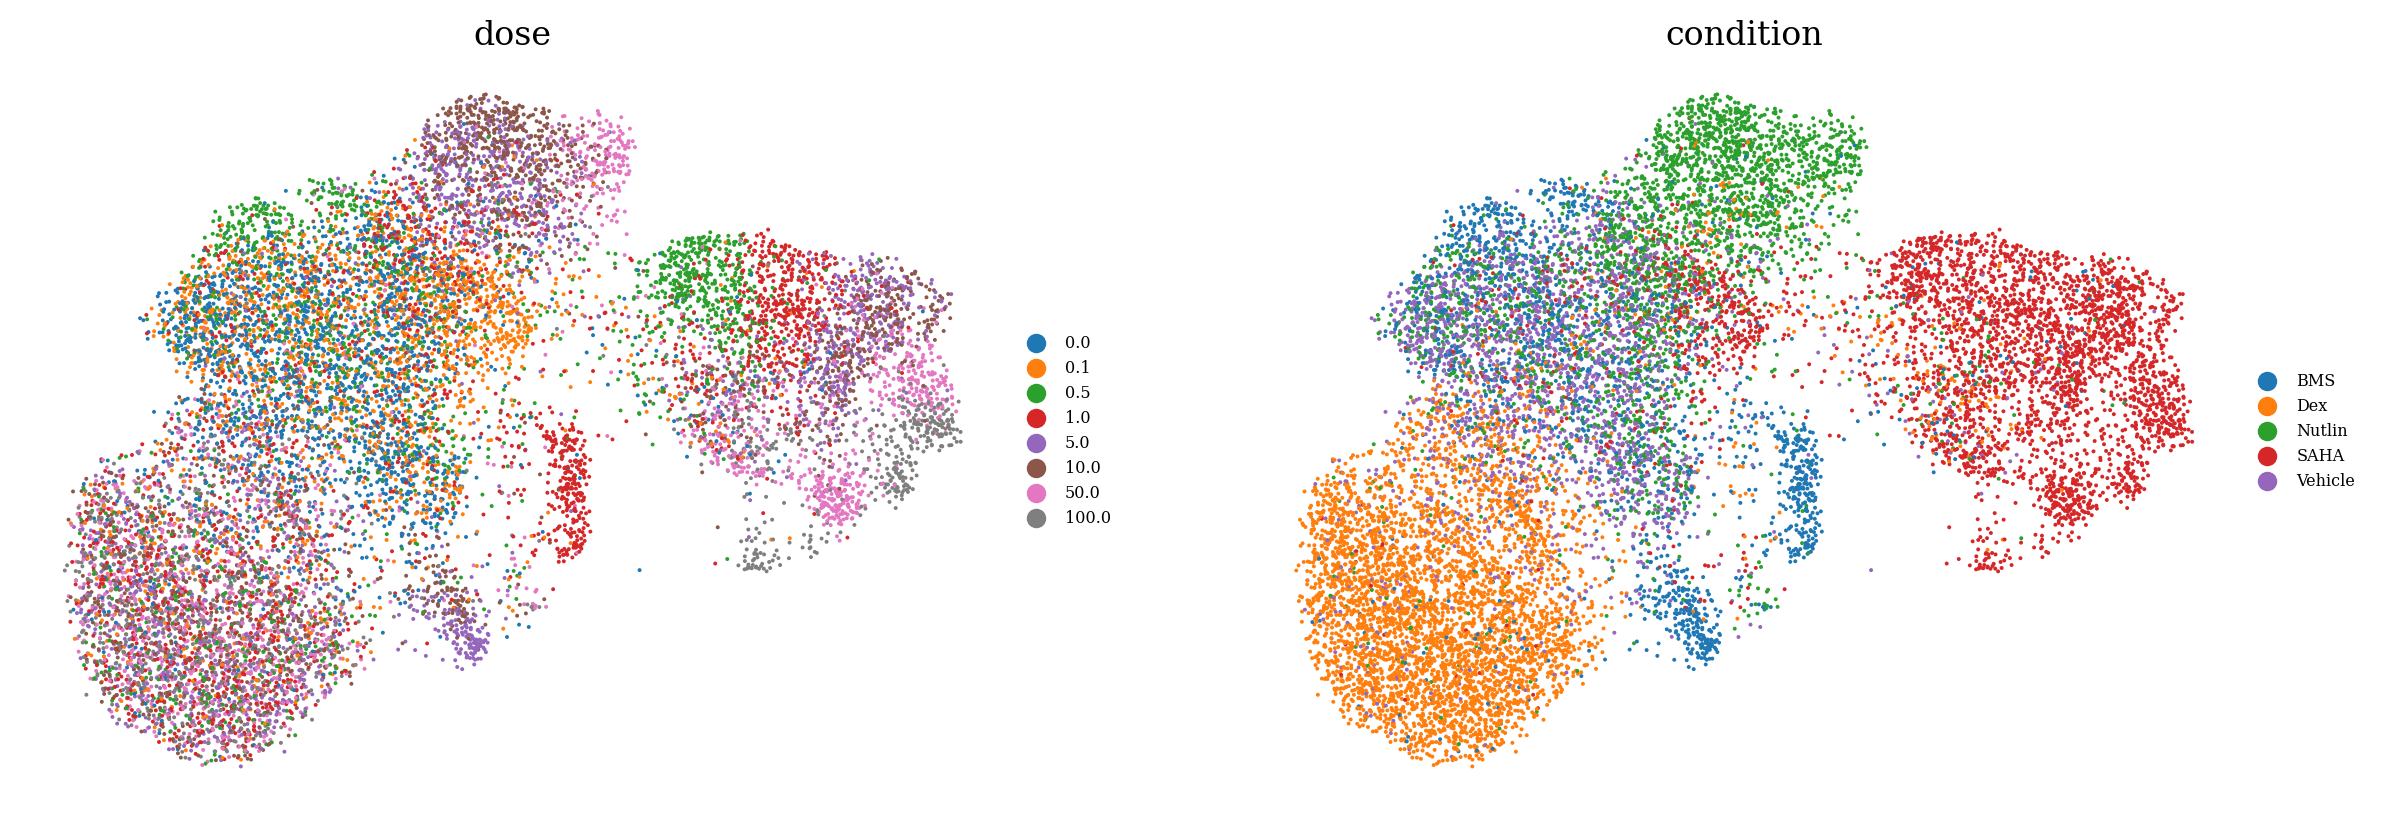

In [20]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

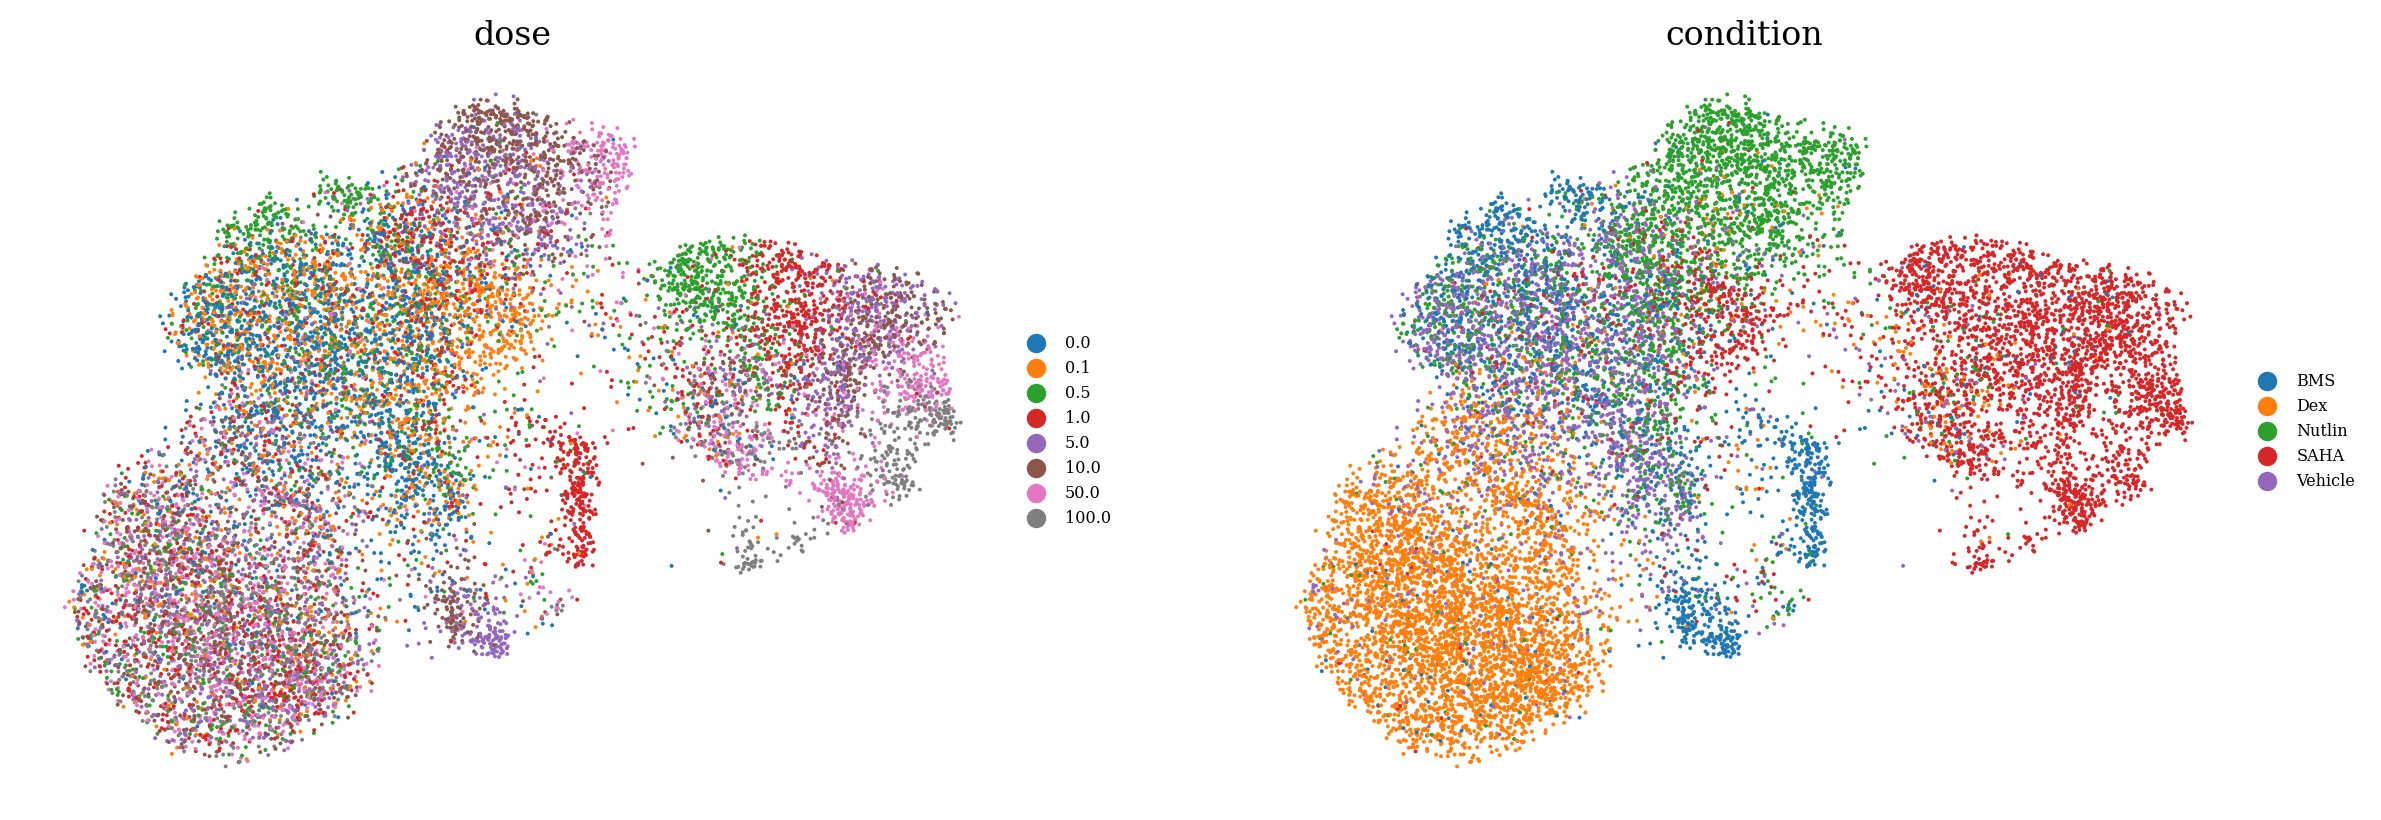

In [21]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [22]:
model.predict()

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 1/463 [00:00<02:09,  3.56it/s]

  6%|▌         | 26/463 [00:00<00:05, 86.41it/s]

 11%|█         | 51/463 [00:00<00:02, 139.20it/s]

 16%|█▋        | 76/463 [00:00<00:02, 172.66it/s]

 22%|██▏       | 101/463 [00:00<00:01, 194.97it/s]

 27%|██▋       | 126/463 [00:00<00:01, 210.80it/s]

 33%|███▎      | 151/463 [00:00<00:01, 221.20it/s]

 38%|███▊      | 176/463 [00:00<00:01, 228.09it/s]

 43%|████▎     | 201/463 [00:01<00:01, 232.49it/s]

 49%|████▉     | 226/463 [00:01<00:01, 236.17it/s]

 54%|█████▍    | 251/463 [00:01<00:00, 238.82it/s]

 60%|█████▉    | 276/463 [00:01<00:00, 240.61it/s]

 65%|██████▌   | 301/463 [00:01<00:00, 242.00it/s]

 70%|███████   | 326/463 [00:01<00:00, 243.04it/s]

 76%|███████▌  | 351/463 [00:01<00:00, 243.72it/s]

 81%|████████  | 376/463 [00:01<00:00, 243.52it/s]

 87%|████████▋ | 401/463 [00:01<00:00, 243.87it/s]

 92%|█████████▏| 426/463 [00:02<00:00, 243.92it/s]

 97%|█████████▋| 451/463 [00:02<00:00, 241.57it/s]

100%|██████████| 463/463 [00:02<00:00, 212.90it/s]

In [23]:
pred_adata = adata[model.test_indices].copy()
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [24]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.9308101701340202

In [25]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)